In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from bams.adaptive_tools import *

# Binary SAMS update scheme example
Drawing independend samples from `numpy`'s multinomial sampler. For simplicity, the target weights will be uniform.

## Asymptotic update only
At iteration time $t$, the bias and estimate $\zeta$ is updated using

$$\zeta^{(t)} =  \zeta^{(t-\frac{1}{2})} - \zeta_{1}^{(t-\frac{1}{2})} $$

with

$$\zeta^{(t-\frac{1}{2})} = \zeta^{(t-1)} + \frac{1}{t}[\delta_1(L_t),..., \delta_m(L_t)] $$

In [2]:
# The number of states and target sampling weight
num_states = 5
target_weight = np.repeat(1.0/num_states, num_states)

# Generating the target free energy from the prior
f_true = -np.random.uniform(-200,200,size=4)
p = np.hstack((1, np.exp(-f_true)))
p = p / np.sum(p)
print('Target:', np.hstack((0,f_true)))

# Setting the initial guess to zero for all states
zetas = [np.repeat(0,5)]

ncycles = 100000
for t in range(1, ncycles+1):
    # Generate one state from multinomial distribution that's specified by the true free energies
    q = p*np.exp(-zetas[-1])
    q = q / np.sum(q)
    state = np.random.multinomial(1,q)
    # Apply SAMS binary update scheme
    zeta_half = zetas[-1] + state/target_weight/float(t)
    zetas.append(zeta_half - zeta_half[0])
estimate = -np.array(zetas)
print('Estimate', estimate[-1])

('Target:', array([   0.        ,  179.91262873,   85.5393755 ,   87.17191359,
       -132.83336392]))
('Estimate', array([ -0.        ,  -0.        ,  -0.        ,  -0.        , -60.45073065]))


Unsurpisingly, this estimate is far from converged. Extending the adaptation process much longer won't help as the adaptations decrease too quickly.

## Two stage procedure
At iteration time $t$, the bias and estimate $\zeta$ is updated using

$$\zeta^{(t)} =  \zeta^{(t-\frac{1}{2})} - \zeta_{1}^{(t-\frac{1}{2})} $$

with

$$\zeta^{(t-\frac{1}{2})} = \zeta^{(t-1)} + \frac{1}{k}[\delta_1(L_t),..., \delta_m(L_t)] $$

with 

$$ k = \text{min}(\pi_j,t^{(-\beta)}) \,\, \text{if} \,\, t \leq t_0$$
$$ k = \text{min}(\pi_j,(t - t _0 + t^{\beta})^{-1}) \,\, \text{if} \,\, t \leq t_0$$

The two-stage procedure is specific for each state. The value $t_0$ is set to the point when the $i$th state is within 20%-50% of the uniform weight.

In [46]:
# The number of states and target sampling weight
beta = 0.501
num_states = 5
target_weight = np.repeat(1.0/num_states, num_states)
cutoff = 0.3
t0 = None

# Generating the target free energy from the prior
f_true = -np.random.uniform(-200,200, size=num_states - 1)
p = np.hstack((1, np.exp(-f_true)))
p = p / np.sum(p)
print('Target:', np.hstack((0,f_true)))

# Setting the initial guess to zero for all states
zetas = [np.repeat(0,5)]
counts = np.repeat(0,5)

ncycles = 5000
for t in range(1, ncycles+1):
    # Generate one state from multinomial distribution that's specified by the true free energies
    q = p*np.exp(-zetas[-1])
    q = q / np.sum(q)
    state = np.random.multinomial(1,q)
    counts += state
    # Calculate whether to terminate burn-in
    state_ind = np.where(state != 0)[0][0]
    fraction = 1.0*counts/np.sum(counts)
    #dist = np.mean(np.absolute(fraction[state_ind] - target_weight[state_ind])/target_weight[state_ind])
    dist = np.mean(np.absolute(fraction - target_weight)/target_weight)
    if dist <= cutoff:
        if t0 is None:
            t0 = t
        else:    
            k = np.min((target_weight[state_ind], (t - t0 + t0**(-beta))**(-1)))
    else:
        k = np.min((target_weight[state_ind], t**(-beta)))
    # Apply SAMS binary update scheme
    zeta_half = zetas[-1] + float(k) * (state / target_weight)
    zetas.append(zeta_half - zeta_half[0])
estimate = -np.array(zetas)
print('Estimate', estimate[-1])

('Target:', array([   0.        ,  198.92814936,    5.38623927, -137.92657028,
         32.98454696]))
('Estimate', array([  -0.        ,  144.3051539 ,    5.49593578, -138.0991433 ,
         32.71308318]))


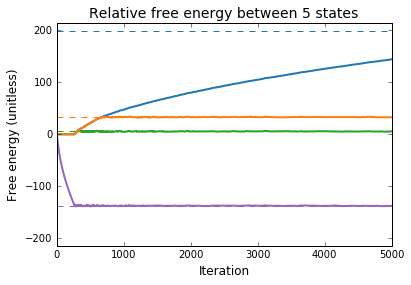

In [47]:
x = np.arange(estimate.shape[0])
for i in range(1,5):
    plt.plot(x, estimate[:,i], color=tableau4[i-1], lw=2)
    plt.axhline(y = f_true[i-1], color=tableau4[i-1], ls='--', lw=1)
plt.ylim((-215,215))
#plt.ylim((-135,-120))
plt.title('Relative free energy between 5 states', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Free energy (unitless)', fontsize=12)
plt.show()

The two stage procedure converges much faster than before, but is not as fast the Bayesian update scheme.